In [4]:
%config InlineBackend.figure_format = 'retina'

In [5]:
import re
import math
import pandas as pd
from orderedset import OrderedSet
from copy import deepcopy
from glob import glob
import numpy as np
from adjustText import adjust_text
import matplotlib
from multiprocessing import Pool
import matplotlib as mpl
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
from scipy.stats import hypergeom, pearsonr, zscore, ttest_ind, fisher_exact
from scipy.stats.mstats import gmean
from matplotlib_venn import venn2, venn3, venn3_circles
import seaborn as sns
import os
from collections import Counter

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"

In [6]:
sns.set_style("ticks")

In [7]:
prefixs = ['con1','con2','con3','sh1','sh2','sh3']

In [9]:
df_ls = []
for prefix in prefixs:
    df = pd.read_csv('./Data/Count/'+prefix+'.counts.txt', sep='\t', index_col=0, header=None)
    df.columns = [prefix]
    df = df.iloc[:-5]
    df_ls.append(df)

In [10]:
count_df = pd.concat(df_ls, axis=1)
count_df = count_df.loc[count_df.sum(axis=1)>0]

In [11]:
## Deseq normalization
def DeseqNorm(data):
    data_df = data/(data.T/data.apply(gmean,axis=1)).dropna(axis=1,how='any').apply(np.median,axis=1)
    datalog_df = np.log2(data_df+1)

    return data_df, datalog_df

## Quantile normalization
def QNorm(data):
    rank_mean = data.stack().groupby(data.rank(method='first').stack().astype(int)).mean()
    data_df = data.rank(method='min').stack().astype(int).map(rank_mean).unstack()
    datalog_df = np.log2(data_df+1)

    return data_df, datalog_df

In [12]:
deseq_df, deseq_log_df = DeseqNorm(count_df)
qnorm_df, qnorm_log_df = QNorm(count_df)

/home/yuqiaoni/.pyenv/versions/anaconda3-5.3.1/envs/jpt/lib/python3.7/site-packages/scipy/stats/stats.py:402: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


In [13]:
deseq_result_df = pd.read_csv('./Data/results.deseq.csv', index_col=0)

In [14]:
ko_down_deseq_result_df = deseq_result_df[deseq_result_df['log2FoldChange']<0]
ko_up_deseq_result_df = deseq_result_df[deseq_result_df['log2FoldChange']>0]

In [15]:
deseq_result_df['logP'] = deseq_result_df['pvalue'].map(lambda x: -math.log10(x))

In [16]:
cut_pval = 0.01
cut_log2fc = 0.5

no_diff_result_df = deseq_result_df[(deseq_result_df['pvalue']>=cut_pval) | (deseq_result_df['log2FoldChange'].map(lambda x:abs(x))<cut_log2fc)]
up_result_df = deseq_result_df[(deseq_result_df['pvalue']<cut_pval) & (deseq_result_df['log2FoldChange']>=cut_log2fc)]
down_result_df = deseq_result_df[(deseq_result_df['pvalue']<cut_pval) & (deseq_result_df['log2FoldChange']<=-cut_log2fc)]
print('Up in KO: {0}'.format(up_result_df.shape[0]))
print('Down in KO: {0}'.format(down_result_df.shape[0]))

Up in KO: 540
Down in KO: 2133


In [17]:
nb_top = 20
up_genes = up_result_df.sort_values('padj').iloc[:nb_top].index.tolist()
down_genes = down_result_df.sort_values('padj').iloc[:nb_top].index.tolist()

In [18]:
refine_deseq_result_df = deepcopy(deseq_result_df)
refine_deseq_result_df.loc[refine_deseq_result_df['logP']>50,'logP'] = 50

In [19]:
cut_pval = 0.01
cut_log2fc = 0.5

no_diff_result_df = refine_deseq_result_df[(refine_deseq_result_df['pvalue']>=cut_pval) | (refine_deseq_result_df['log2FoldChange'].map(lambda x:abs(x))<cut_log2fc)]
up_result_df = refine_deseq_result_df[(refine_deseq_result_df['pvalue']<cut_pval) & (refine_deseq_result_df['log2FoldChange']>=cut_log2fc)]
down_result_df = refine_deseq_result_df[(refine_deseq_result_df['pvalue']<cut_pval) & (refine_deseq_result_df['log2FoldChange']<=-cut_log2fc)]
print('Up in KO: {0}'.format(up_result_df.shape[0]))
print('Down in KO: {0}'.format(down_result_df.shape[0]))

Up in KO: 540
Down in KO: 2133


# Fig S5F

In [21]:
nb_top = 60
up_genes = up_result_df.sort_values('padj').iloc[:nb_top].index.tolist()
down_genes = down_result_df.sort_values('padj').iloc[:nb_top].index.tolist()

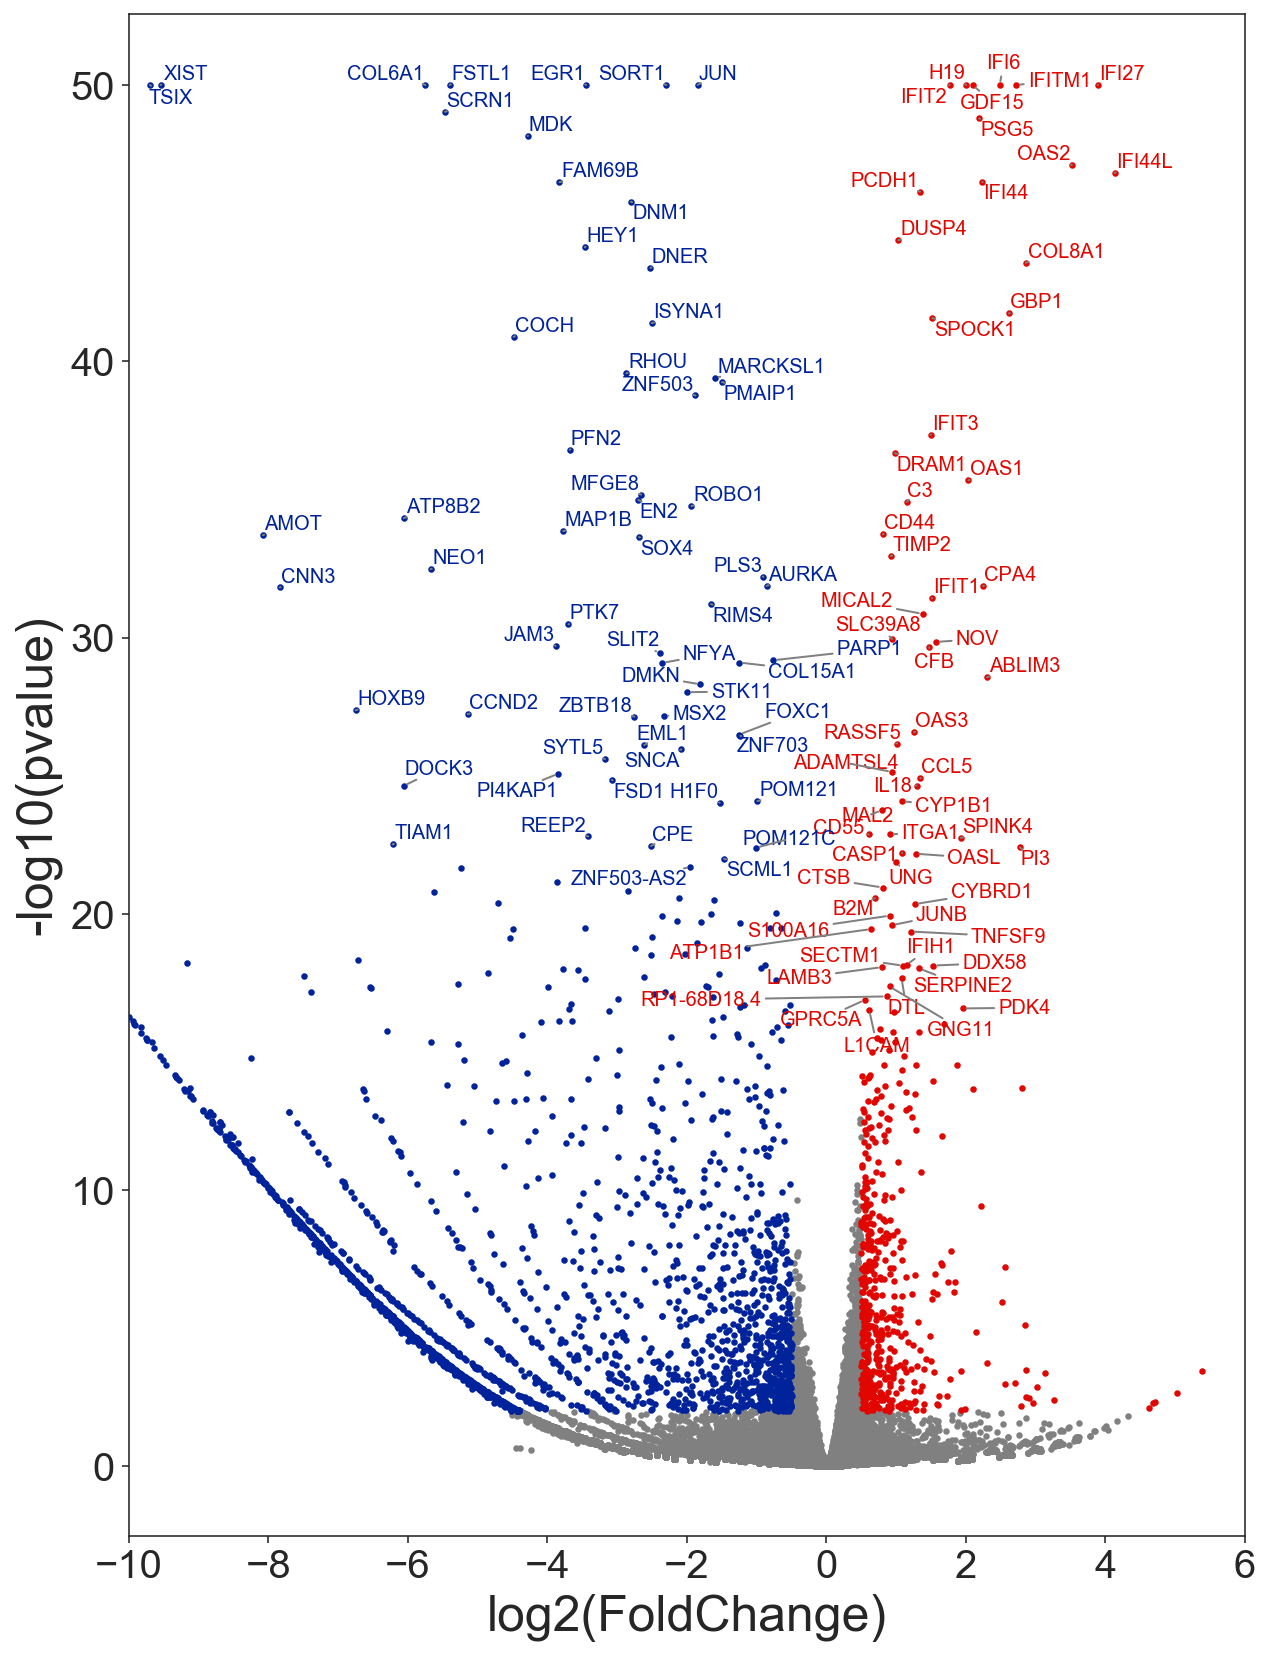

In [23]:
fig = plt.figure(figsize=(10,14))
ax21 = plt.subplot(111)
# bax = brokenaxes(ylims=((0,12), (45,47)))
ax21.scatter(no_diff_result_df['log2FoldChange'], no_diff_result_df['logP'], s=5, c='grey', rasterized=True)
ax21.scatter(up_result_df['log2FoldChange'], up_result_df['logP'], s=5, c='#E10600FF', label='Up in KO', rasterized=True)
ax21.scatter(down_result_df['log2FoldChange'], down_result_df['logP'], s=5, c='#00239CFF', label='Down in KO', rasterized=True)
_ = ax21.set_xlim([-10,6])
# _ = ax21.set_ylim([0,11])
texts1 = [ax21.text(up_result_df.loc[x,'log2FoldChange'],up_result_df.loc[x,'logP'],x,c='#E10600FF') for x in up_genes]
texts2 = [ax21.text(down_result_df.loc[x,'log2FoldChange'],down_result_df.loc[x,'logP'],x,c='#00239CFF') for x in down_genes]
adjust_text(texts1+texts2, arrowprops=dict(arrowstyle='-', color='grey'))
# _ = ax21.legend(loc='best')
_ = ax21.set_xlabel('log2(FoldChange)', fontsize=25)
_ = ax21.set_ylabel('-log10(pvalue)', fontsize=25)
for tick in ax21.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax21.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

# Fig 3E

Text(0, 0.5, 'nGenes')

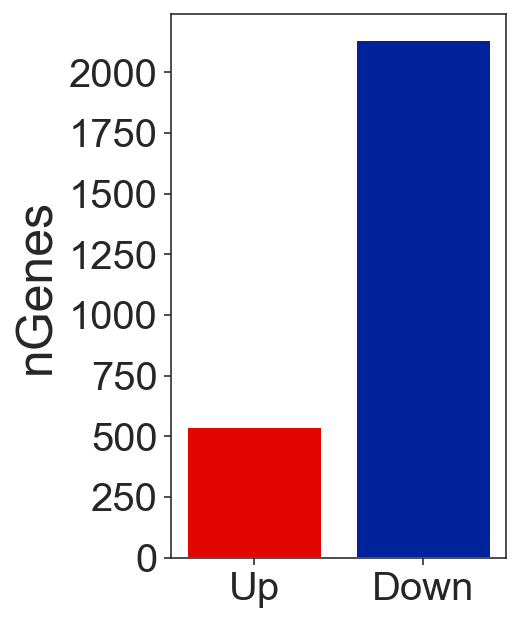

In [20]:
plt.figure(figsize=(3,5))
plt.bar(['Up','Down'], [up_result_df.shape[0],down_result_df.shape[0]], 
        color=['#E10600FF','#00239CFF'])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('nGenes', fontsize=25)

In [26]:
nfya_cuttag_anno_df = pd.read_csv('./Data/NFYA_anno.txt', 
                                  sep='\t', index_col=0)

In [27]:
nfya_target_genes = nfya_cuttag_anno_df['Gene Name'].unique().tolist()
nfya_target_genes.remove(np.nan)

In [28]:
len(set(nfya_target_genes).intersection(set(up_genes)))

12

In [29]:
cut_pval = 0.01
cut_log2fc = 0.5

up_result_df = refine_deseq_result_df[(refine_deseq_result_df['pvalue']<cut_pval) & (refine_deseq_result_df['log2FoldChange']>=cut_log2fc)]
down_result_df = refine_deseq_result_df[(refine_deseq_result_df['pvalue']<cut_pval) & (refine_deseq_result_df['log2FoldChange']<=-cut_log2fc)]
print('Up in KO: {0}'.format(up_result_df.shape[0]))
print('Down in KO: {0}'.format(down_result_df.shape[0]))

Up in KO: 540
Down in KO: 2133


In [30]:
up_genes = up_result_df.index.tolist()
down_genes = down_result_df.index.tolist()

In [31]:
pos_ratio = len(set(nfya_target_genes).intersection(set(down_genes))) / len(down_genes)
neg_ratio = len(set(nfya_target_genes).intersection(set(up_genes))) / len(up_genes)

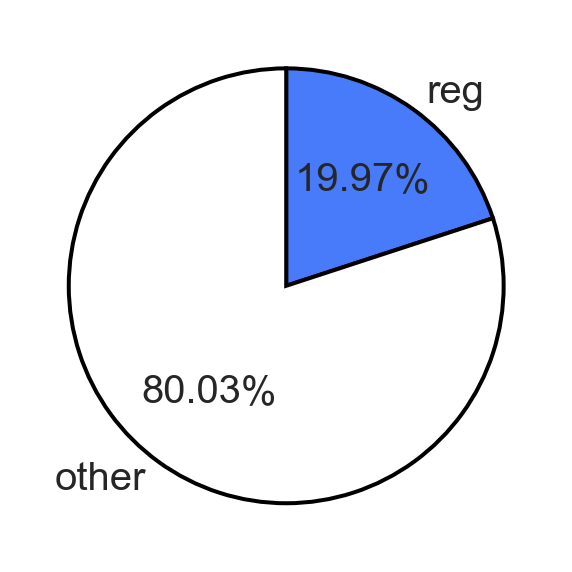

In [32]:
fig = plt.figure(figsize=(5,5))

ax21 = plt.subplot(111)
g = ax21.pie([pos_ratio, 1-pos_ratio],
             labels=['reg','other'], explode=[0,0], autopct='%1.2f%%', 
             startangle=90, textprops={'fontsize': 20},
             counterclock=False, colors=['#487bf9','white']) 
for w in g[0]:
    w.set_linewidth(2)
    w.set_edgecolor('black')

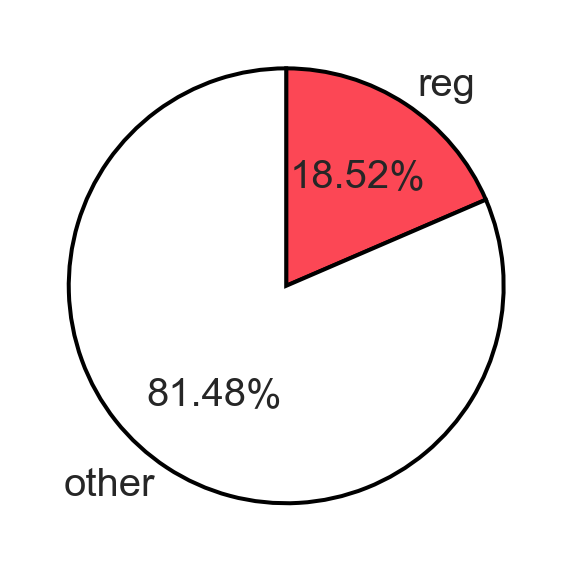

In [33]:
fig = plt.figure(figsize=(5,5))

ax21 = plt.subplot(111)
g = ax21.pie([neg_ratio, 1-neg_ratio],
             labels=['reg','other'], explode=[0,0], autopct='%1.2f%%', 
             startangle=90, textprops={'fontsize': 20},
             counterclock=False, colors=['#fc4755','white']) 
for w in g[0]:
    w.set_linewidth(2)
    w.set_edgecolor('black')